<a href="https://colab.research.google.com/github/nina-prog/DataAnalysis_VAE/blob/main/VAE_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Dropout, Reshape, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### set plot design
sns.set()
sns.set_palette(sns.color_palette("Set1"))  # tab10 #viridis
# sns.set_style("whitegrid")
sns.set_context("paper")

### set seed
tf.random.set_seed(7)

# Data Preprocessing

---



## Load Data

In [84]:
### Load ecg5000 data using read_csv
ecg5000 = pd.read_csv('ECG5000_ALL.txt', sep='\s+', header=None)

In [85]:
### Optional test and info about data set
print("Type of ecg5000: \t \t {}".format(type(ecg5000)))
print("Dimensions of ecg5000: \t \t {}".format(ecg5000.shape))
print("Number of elements of ecg5000: \t {}".format((ecg5000.size)))
print("Display first 10 rows of ecg5000: \n {}".format(ecg5000.head(10)))

Type of ecg5000: 	 	 <class 'pandas.core.frame.DataFrame'>
Dimensions of ecg5000: 	 	 (5000, 141)
Number of elements of ecg5000: 	 705000
Display first 10 rows of ecg5000: 
    0         1         2         3    ...       137       138       139       140
0  1.0 -0.112522 -2.827204 -3.773897  ...  0.228077  0.123431  0.925286  0.193137
1  1.0 -1.100878 -3.996840 -4.285843  ...  0.476333  0.773820  1.119621 -1.436250
2  1.0 -0.567088 -2.593450 -3.874230  ... -0.532197  0.321097  0.904227 -0.421797
3  1.0  0.490473 -1.914407 -3.616364  ...  0.990133  1.086798  1.403011 -0.383564
4  1.0  0.800232 -0.874252 -2.384761  ...  0.960304  0.971020  1.614392  1.421456
5  1.0 -1.507674 -3.574550 -4.478011  ...  1.007076  1.634990  1.493366 -0.783134
6  1.0 -0.297161 -2.766635 -4.102185  ...  0.974787  1.110407  1.288165 -0.823386
7  1.0  0.446769 -1.507397 -3.187468  ...  1.034388  1.258433  0.961215 -0.999476
8  1.0  0.087631 -1.753490 -3.304473  ...  0.573453  0.192971 -0.648683 -2.441068
9  1.0

In [86]:
# ### Normalize dataframe with min-max-normalization to range between [-0.8, 0.8] using sklearn MinMaxScaler
# min_max_scaler = MinMaxScaler(feature_range=(-0.8,0.8))
# scaled_ecg5000 = pd.DataFrame(min_max_scaler.fit_transform(ecg5000))
# print(scaled_ecg5000)

## Split Data

In [87]:
### Split Data into 80/20 Training, Test
trainDF, testDF = train_test_split(ecg5000, test_size=0.2, shuffle=True, random_state=1)

# get all labels from trainDF and then drop it
trainDF_Y = trainDF.iloc[:,0]
trainDF.drop(trainDF.columns[[0]], axis=1, inplace=True)

# get all labels from testDF and then drop it
testDF_Y = testDF.iloc[:,0]
testDF.drop(testDF.columns[[0]], axis=1, inplace=True)

# optional test and info about new data sets
print("Shape of Train DataFrame: \t {}".format(trainDF.shape))
print("Shape of Test DataFrame: \t {}".format(testDF.shape))
print("Shape of Train Y DataFrame: \t {}".format(trainDF_Y.shape))
print("Shape of Test Y DataFrame: \t {}".format(testDF_Y.shape))

Shape of Train DataFrame: 	 (4000, 140)
Shape of Test DataFrame: 	 (1000, 140)
Shape of Train Y DataFrame: 	 (4000,)
Shape of Test Y DataFrame: 	 (1000,)


## Reshape Data

In [88]:
### Convert to array
x_train = trainDF.to_numpy()
x_test = testDF.to_numpy()

y_train = trainDF_Y.to_numpy()
y_test = testDF_Y.to_numpy()

### Reshape datasets X/Y train/test into [samples, time steps, features]
s_x_train = len(trainDF.index)  # samples
n_x_train = len(trainDF.columns)  # time steps

s_x_test = len(testDF.index)  # samples
n_x_test = len(testDF.columns)  # time steps

s_y_train = len(trainDF_Y.index)  # samples

s_y_test = len(testDF_Y.index)  # samples

x_train = x_train.reshape(s_x_train, n_x_train, 1)
x_test = x_test.reshape(s_x_test, n_x_test, 1)

y_train = y_train.reshape(s_y_train, 1, 1)
y_test = y_test.reshape(s_y_test, 1, 1)

### Properties
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))

print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (4000, 140, 1)
Shape of x_test: (1000, 140, 1)
Shape of y_train: (4000, 1, 1)
Shape of y_test: (1000, 1, 1)


# Sampling

---



In [89]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build Variational Autoencoder (VAE)

---



## Encoder

In [90]:
def create_encoder(intermediate_dim=140, latent_dim=5, dropout_rate=0.2, regularizer_rate=0.004):
    """Maps ECG5000 time series to a triplet (z_mean, z_log_var, z)."""

    ### Define Layers
    encoder_inputs = keras.Input(shape=(140, 1), name='Encoder_Input_layer')

    encoded = Bidirectional(LSTM(intermediate_dim, activation='tanh', name=''), name='Encode_1')(encoder_inputs)
    # encoded = Flatten()(encoded), LSTM return_sequence=True
    encoded = Dropout(dropout_rate, name='Dropout_1')(encoded)
    encoded = Dense(latent_dim, activation='tanh', name='Encode_2', kernel_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate))(encoded)

    z_mean = Dense(latent_dim, activation='softplus', name="z_mean")(encoded)
    z_log_var = Dense(latent_dim, activation='softplus', name="z_log_var")(encoded)
    z = Sampling(name='Sample_layer')([z_mean, z_log_var])

    ### Instantiate encoder
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

In [91]:
### Check if encoder works
encoder_test = create_encoder() 
encoder_test.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
Encode_1 (Bidirectional)        (None, 280)          159040      Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
Dropout_1 (Dropout)             (None, 280)          0           Encode_1[0][0]                   
__________________________________________________________________________________________________
Encode_2 (Dense)                (None, 5)            1405        Dropout_1[0][0]                  
____________________________________________________________________________________________

## Decoder

In [92]:
def create_decoder(encoding_dim=140, intermediate_dim=140, latent_dim=5, dropout_rate=0.2,
                   regularizer_rate=0.004):
    """Converts z, the encoded time series, back into a readable time series."""

    ### Define Layers
    latent_inputs = keras.Input(shape=(latent_dim,), name='Decoder_Input_layer')

    decoded = Dense(encoding_dim * 256, activation='tanh', name='Decode_1', kernel_regularizer=l2(regularizer_rate),
                    activity_regularizer=l2(regularizer_rate))(latent_inputs)
    decoded = Reshape((140, 256), name='Decode_2')(decoded)
    decoded = Dropout(dropout_rate, name='Dropout_1')(decoded)
    decoded = Bidirectional(LSTM(intermediate_dim, activation='tanh', return_sequences=True, name=''), name='Decode_3')(
         decoded)

    decoder_outputs = TimeDistributed(Dense(1, activation='linear', name=''), name='Decoder_Output_Layer')(decoded)

    ### Instantiate decoder
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder


In [93]:
### Check if decoder works
decoder_test = create_decoder()
decoder_test.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input_layer (InputLa [(None, 5)]               0         
_________________________________________________________________
Decode_1 (Dense)             (None, 35840)             215040    
_________________________________________________________________
Decode_2 (Reshape)           (None, 140, 256)          0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 140, 256)          0         
_________________________________________________________________
Decode_3 (Bidirectional)     (None, 140, 280)          444640    
_________________________________________________________________
Decoder_Output_Layer (TimeDi (None, 140, 1)            281       
Total params: 659,961
Trainable params: 659,961
Non-trainable params: 0
_____________________________________________________

## VAE

### Define VAE Model

In [94]:
class VAE(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        # unpack the data
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Compute own loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction) * 140
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        # compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        # update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # compute own metrics
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        # unpack the data
        x, y = data
        # compute predictions
        y_pred = self(x, training=False)
        # updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        # return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def call(self, data, **kwargs):
        z_mean, z_log_var, z = self.encoder(data)
        reconstructed = self.decoder(z)
        return reconstructed

### Build VAE connecting Encoder and Decoder

In [95]:
### Define function to create model
def create_model(intermediate_dim=140, dropout_rate=0.2, regularizer_rate=0.004, optimizer='adam', learn_rate=0.001,
                 name='VAE'):
    """Creates VAE model, required for wrapping in estimator interface KerasRegressor, while accepting the hyperparameters we want to tune. We also pass some default values."""

    # create encoder 
    encoder = create_encoder(intermediate_dim=intermediate_dim, dropout_rate=dropout_rate,
                             regularizer_rate=regularizer_rate)
    # create decoder 
    decoder = create_decoder(intermediate_dim=intermediate_dim, dropout_rate=dropout_rate,
                             regularizer_rate=regularizer_rate)
    # create vae
    model = VAE(encoder, decoder, name=name)
    # compile model
    if optimizer == 'adam':
        opt = Adam(lr=learn_rate, amsgrad=True)
    else:
        opt = SGD(lr=learn_rate)
    model.compile(optimizer=opt)
    model.build((None, 140, 1))

    return model

In [96]:
### Instantiate VAE model
vae = create_model(name='VAE')

### Display VAE model and it`s parts
# encoder 
vae.encoder.summary(line_length=100)
plot_model(vae.encoder, show_shapes=True, to_file='vae_encoder.png')
print("\n")
# decoder
vae.decoder.summary(line_length=100)
plot_model(vae.decoder, show_shapes=True, to_file='vae_decoder.png')
print("\n")
# vae
vae.summary(line_length=100)

Model: "encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Encoder_Input_layer (InputLayer) [(None, 140, 1)]      0                                            
____________________________________________________________________________________________________
Encode_1 (Bidirectional)         (None, 280)           159040      Encoder_Input_layer[0][0]        
____________________________________________________________________________________________________
Dropout_1 (Dropout)              (None, 280)           0           Encode_1[0][0]                   
____________________________________________________________________________________________________
Encode_2 (Dense)                 (None, 5)             1405        Dropout_1[0][0]                  
__________________________________________________________________________

# Train VAE

---



In [97]:
### Train Properties
epochs = 100 #50, 100
batch_size = 16 #16, 32

## Train

In [98]:
### Train
train_history = vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Epoch 1/100
250/250 [==============================] - 14s 43ms/step - loss: 48.3072 - reconstruction_loss: 46.9839 - kl_loss: 1.3233 - val_loss: 0.8921
Epoch 2/100
250/250 [==============================] - 10s 40ms/step - loss: 37.4587 - reconstruction_loss: 35.6351 - kl_loss: 1.8236 - val_loss: 1.3672
Epoch 3/100
250/250 [==============================] - 10s 40ms/step - loss: 35.6701 - reconstruction_loss: 33.6403 - kl_loss: 2.0298 - val_loss: 1.7806
Epoch 4/100
250/250 [==============================] - 10s 40ms/step - loss: 34.0549 - reconstruction_loss: 31.8974 - kl_loss: 2.1575 - val_loss: 2.0474
Epoch 5/100
250/250 [==============================] - 10s 40ms/step - loss: 33.2542 - reconstruction_loss: 30.8923 - kl_loss: 2.3619 - val_loss: 2.6428
Epoch 6/100
250/250 [==============================] - 10s 40ms/step - loss: 31.9332 - reconstruction_loss: 29.3865 - kl_loss: 2.5467 - val_loss: 2.9419
Epoch 7/100
250/250 [==============================] - 10s 40ms/step - loss: 30.29

In [99]:
### Save history
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(train_history.history, file_pi)

In [100]:
### Check displayed values in the command line with actual output values of the trainings process
print("----- loss: -----\n{}".format(train_history.history["loss"]))
print("----- reconstruction_loss: -----\n{}".format(train_history.history["reconstruction_loss"]))
print("----- kl_loss: -----\n{}".format(train_history.history["kl_loss"]))
print("----- val_loss: -----\n{}".format(train_history.history["val_loss"]))

----- loss: -----
[28.225244522094727, 32.94031524658203, 24.503877639770508, 29.71958351135254, 31.644916534423828, 36.70085906982422, 32.556575775146484, 35.36183547973633, 25.586862564086914, 37.968692779541016, 33.24756622314453, 30.127750396728516, 20.258644104003906, 15.084606170654297, 23.919729232788086, 21.103557586669922, 27.34408950805664, 23.133617401123047, 36.5202751159668, 19.949756622314453, 17.84628677368164, 19.717533111572266, 14.939718246459961, 19.141666412353516, 34.00772476196289, 13.216126441955566, 20.081302642822266, 17.12826919555664, 13.35066032409668, 16.158666610717773, 17.39581871032715, 21.8358211517334, 18.508312225341797, 16.31109046936035, 17.9685115814209, 20.742568969726562, 18.534549713134766, 20.004762649536133, 16.416954040527344, 16.957374572753906, 20.9217529296875, 15.113426208496094, 17.71199607849121, 13.703875541687012, 13.996755599975586, 18.483524322509766, 13.843814849853516, 13.167306900024414, 18.914445877075195, 13.043267250061035, 11

## Recreate

In [101]:
# Encoder output is a list [z_mean, z_log_var, z] thus list[2] = z, see subsection encoder line 12

### Extract myu i.e. z_mean
z_mean = vae.encoder.predict(x_test)[0]
print("----- z_mean: -----")
print(z_mean)
print("\n")

### Extract sigma i.e. z_log_var
z_log_var = vae.encoder.predict(x_test)[1]
print("----- z_log_var: -----")
print(z_log_var)
print("\n")

### Extract z_values and predict x_test
z_values = vae.encoder.predict(x_test)[2]
decoded_ecg5000 = vae.decoder.predict(z_values)
# z_values contains list of each z_value per sample, i.e. we get 1000 SubLists with 5 elements in each.
# Those 5 elements (z_values for Sample i) is our bottleneck which the decoder recieves.
print("----- z_values: -----")
print(z_values)
print("\n")

### Save extracted values
np.savetxt('z_values.csv', z_values, delimiter=",")
np.savetxt('decoded_ecg5000.csv', decoded_ecg5000.reshape(-1,140), delimiter=",")

### Properties
print("Shape and Type of z_mean: {}, {}".format(z_mean.shape, type(z_mean)))
print("Shape and Type of z_log_var: {}, {}".format(z_log_var.shape, type(z_log_var)))
print("Shape and Type of z_values: {}, {}".format(z_values.shape, type(z_values)))
print("Shape and Type of decoded_ecg5000: {}, {}".format(decoded_ecg5000.shape, type(decoded_ecg5000)))

----- z_mean: -----
[[2.1025041e-01 2.3201173e-04 4.0867117e-01 7.4463091e+00 1.8929193e+00]
 [1.2719464e+00 6.7239900e+00 5.8037400e-01 2.2844586e-04 5.6659780e-02]
 [3.7965293e+00 4.5101008e+00 1.1539998e-02 2.3417776e-04 1.3764617e-01]
 ...
 [4.3514267e-02 4.5292931e+00 1.5241024e+00 4.4240378e-04 1.2085331e-01]
 [1.0051730e+01 7.8175575e-01 7.9967576e-05 2.1259136e-01 1.3571405e+00]
 [5.8815968e-01 2.7293677e-02 3.8741723e-02 6.7804569e-01 2.4805400e+00]]


----- z_log_var: -----
[[0.0192629  0.09467833 0.02053413 0.00712737 0.0314046 ]
 [0.00924563 0.00816151 0.02234097 0.08212581 0.10155524]
 [0.00506128 0.00836913 0.03557318 0.06010819 0.09393131]
 ...
 [0.00452115 0.00346664 0.00552184 0.02072788 0.0291327 ]
 [0.00270124 0.02930763 0.06935376 0.04992682 0.11816565]
 [0.00223725 0.00952627 0.00557733 0.00584069 0.01472484]]


----- z_values: -----
[[ 1.502697    0.66785413  1.1103566   6.394308    3.4260375 ]
 [ 1.8530389   7.377696    2.2505932  -0.6767069  -0.33996412]
 [ 4.72

## Display the training progress

#### Loss

In [ ]:
### Loss vs Reconstruction_loss vs KL Divergence
plt.figure(figsize=(8,5))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['reconstruction_loss'])
plt.plot(train_history.history['kl_loss'])
plt.legend(["Loss", "Reconstruction Loss", "KL Divergence"])
plt.xlabel("Epoch")
plt.title("Loss vs. Reconstruction Loss vs. KL Divergence")

plt.savefig('loss.png')

In [ ]:
### Train loss vs val loss
# returns the loss value & metrics values for the model in test mode
plt.figure(figsize=(8,5))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(["Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.title("Loss vs. Validation Loss")

plt.savefig('valLoss.png')

### Latent Space

In [ ]:
### Scale Datan (PCA)
# transform to dataframe
z_test = pd.DataFrame(z_values)
# standardize the data
z_test = StandardScaler().fit_transform(z_test)

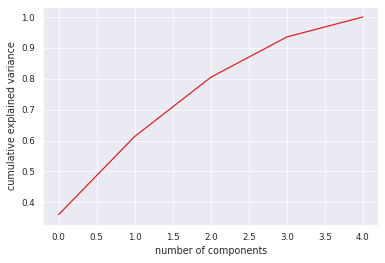

In [102]:
### Estimate how many components are needed to describe the data (PCA)
pca_explained = PCA().fit(z_test)
plt.plot(np.cumsum(pca_explained.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
### PCA (5 dim -> 2 dim): display a 2D plot of the classes in the latent space.
# make PCA instance
pca = PCA(n_components=2)
# fit transform features
principalComponents = pca.fit_transform(z_test)
# build pca dataframe
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
targetDF = pd.DataFrame(data=testDF_Y.to_numpy(), columns=['target'])
finalDF = pd.concat([principalDf, targetDF], axis=1)
# scatterplot
plt.figure(figsize=(8, 5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis of Latent Space')
plt.scatter(finalDF['principal component 1'], finalDF['principal component 2'], c=finalDF['target'],
            cmap=plt.cm.get_cmap('Set1', 6), s=40, alpha=0.7)  # or cmap=hsv
plt.colorbar(ticks=range(6), label='Classes of ECG500')
plt.clim(-0.5, 5.5)

plt.show()
plt.savefig('PCA.png')

# Plot Data Results

---



In [103]:
### Test if Input fits Dim of Output
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of decoded_ecg5000: {}".format(decoded_ecg5000.shape))

### Covert to 2D Array ("-1" = make a dimension (here rows) the size that will use the remaining unspecified elements)
new_x_train= x_train.reshape(-1,140)
new_decoded_ecg5000 = decoded_ecg5000.reshape(-1,140)

print("Shape of Input after reshaping: {}".format(new_x_train.shape))
print("Shape of Output after reshaping: {}".format(new_decoded_ecg5000.shape))

Shape of x_train: (4000, 140, 1)
Shape of decoded_ecg5000: (1000, 140, 1)
Shape of Input after reshaping: (4000, 140)
Shape of Output after reshaping: (1000, 140)


In [104]:
# ### Plot figure for paper
# i = 934 # sample which is going to be plotted
# plt.figure(linewidth = 1, figsize=(25,6))
# plt.xlabel('time steps')
# plt.plot(new_x_train[i])
# plt.show()
# plt.savefig('diagramm_original.jpg')

# plt.figure(linewidth = 1, figsize=(25,6))
# plt.xlabel('time steps')
# plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
# plt.show()
# plt.savefig('diagramm_decoded.jpg')

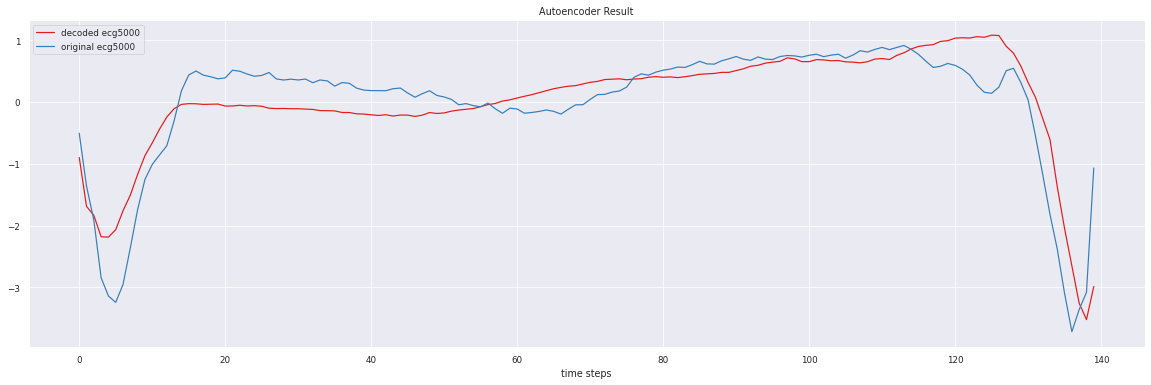

In [105]:
### Plot only one sample
i = 901  # sample which is going to be plotted
plt.figure(linewidth=1, figsize=(20, 6))
plt.title('Autoencoder Result')
plt.xlabel('time steps')
plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
plt.plot(new_x_train[i], label='original ecg5000')
plt.legend(loc="upper left")
plt.show()

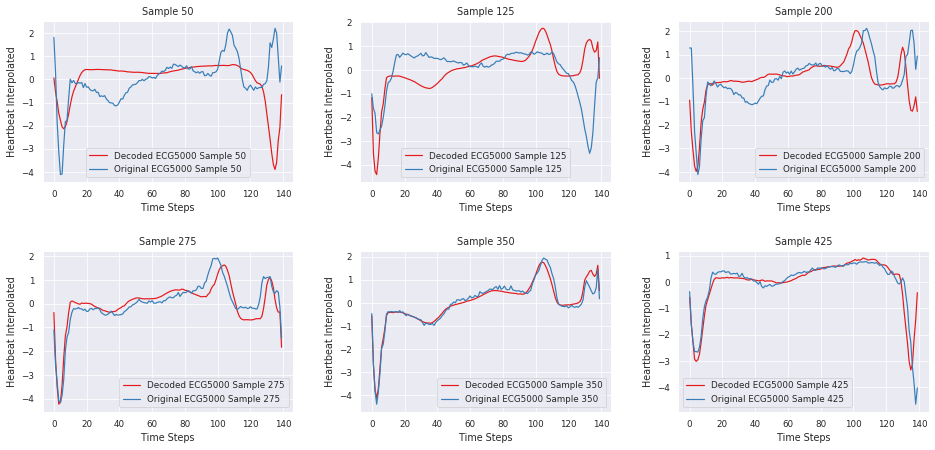

In [106]:
### Plot Multiple Samples
n_rows = 2
n_cols = 3

# size properties and layout design for tighter representation
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(13, 6))
fig.tight_layout(w_pad=4, h_pad=5)

# subplotting
i = 50
for row in range(n_rows):
    for col in range(n_cols):
        axs[row, col].plot(new_decoded_ecg5000[i])
        axs[row, col].plot(new_x_train[i])
        axs[row, col].legend(["Decoded ECG5000 Sample {}".format(i), "Original ECG5000 Sample {}".format(i)])
        axs[row, col].set(xlabel="Time Steps", ylabel="Heartbeat Interpolated", title="Sample {}".format(i))
        i = i + 75

plt.savefig('dataComparison.png')

# Optimization

---

## Hyperparameter (Sckit_GridSearchCV)

In [107]:
### Define scorer
def score_mse(y_true, y_pred): # , **kwargs
    """Implementing mean squarred error as a score for RandomizedSearchCV."""

    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    # removing all size 1 dimensions in y_true
    y_true = tf.squeeze(y_true)
    return np.mean(tf.math.squared_difference(y_pred, y_true))

### Define Function for Randomized Search
def randomizedSearch_pipeline(x_train_data, x_test_data, model, space, n_iter=10, scoring_fit='neg_mean_squared_error',
                              cv=5, do_probabilities=False):
    """Pipeline for RandomizedSearchCV: Select settings and run randomizedSearchCV, returning results."""
    # define randomizedSearch
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=space,
        n_iter=n_iter,
        scoring=scoring_fit,
        n_jobs=1,
        cv=cv,
        verbose=2,
        random_state=1,
    )
    # fit model
    fitted_model = rs.fit(x_train_data, x_train_data, verbose=0)
    # get results
    rs_result = pd.DataFrame(rs.cv_results_)
    # save compromised version of the results
    min_rs_results = pd.concat([pd.DataFrame(rs.cv_results_["mean_test_score"], columns=["score"]),
                                pd.DataFrame(rs.cv_results_["params"])], axis=1)
    min_rs_results = min_rs_results.sort_values(by="score", ascending=False)
    min_rs_results.to_latex(buf='randomizedSearchResults.tex', caption=(
        "Results of 20 candidates using a cross-validation of 5", "Randomized Search Results"), label='table:1')

    if do_probabilities:
        pred = fitted_model.predict_proba(x_test_data)
    else:
        pred = fitted_model.predict(x_test_data)

    return fitted_model, pred, rs_result, min_rs_results

In [114]:
## Define evaluated params and it's value range

space = {
    'optimizer': ['adam', 'SGD'],
    'batch_size': [1, 2, 4, 8, 16, 32, 64],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'regularizer_rate': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1],
    'learn_rate': [0.002, 0.005, 0.008, 0.013, 0.023, 0.038, 0.064, 0.107, 0.179, 0.299, 0.5],    
}

### Wrap keras custom VAE model with the KerasClassifier thus it implements estimator interface
model = KerasRegressor(build_fn=create_model)

### Run RandomizedSearch
fitted_model, pred, rs_result, min_rs_results = randomizedSearch_pipeline(x_train, x_test, model, space, n_iter=30,
                                                                          scoring_fit=make_scorer(score_mse,
                                                                                                  greater_is_better=False))

[CV]  regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4, total=  33.6s
[CV] regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4 
[CV]  regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4, total=  33.7s
[CV] regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4 
[CV]  regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4, total=  33.4s
[CV] regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4 
[CV]  regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4, total=  35.3s
[CV] regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4 
[CV]  regularizer_rate=1e-05, optimizer=adam, learn_rate=0.005, dropout_rate=0.9, batch_size=4, total=  33.9s
[CV] regularizer_rate=0.001, optimizer=SGD, learn_rate=0.107, dropout_

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 92.7min finished


In [115]:
### Summarize results
print("----- Results RandomizedSearchCV: -----\n" + "Best: {} using {}\n".format(fitted_model.best_score_,
                                                                                 fitted_model.best_params_))
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# pd.reset_option('all')
print("Summary:\n {}".format(rs_result))

----- Results RandomizedSearchCV: -----
Best: -0.23407492339611052 using {'regularizer_rate': 0.0001, 'optimizer': 'SGD', 'learn_rate': 0.002, 'dropout_rate': 0.5, 'batch_size': 4}

Summary:
     mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       12.204293      0.295309  ...        0.012069                2
1       85.089173      1.477019  ...             NaN               15
2       17.063744      0.321308  ...             NaN               19
3       12.152807      0.213736  ...             NaN               23
4       91.746168      2.284165  ...             NaN               27
5       28.799980      0.840025  ...             NaN               14
6       28.524418      0.967220  ...             NaN               29
7       13.174070      0.086551  ...        0.083091                8
8       94.640162      2.249879  ...        0.064883                5
9       12.802959      0.247815  ...        0.089407                3
10      30.011000      0.314305  ...  

## Dropout

In [110]:
# ###Dropout_rate

# # configure the experiment
# def experiment_dropout():
#   # configure the experiment
#   n_dropout = [0.0, 0.2, 0.4, 0.6, 0.8]
#   # run the experiment
#   results = []
#   for drop_value in n_dropout:
#       # set dropout
#       drop_out_rate = drop_value
#       print("----- Dropout Rate: {} -----".format(drop_out_rate))
#       # evaluate
#       # rather shorten code with defining a train function of code above and using it here
#       vae = VAE(encoder, decoder, name="VAE")
#       vae.compile(optimizer='adam', loss='mean_squared_error')
#       history = vae.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=0)
#       # report performance
#       # rather make a dataframe or something different which is simpler to plot
#       evaluation = []
#       evaluation.append(vae.evaluate(x_test, y_test))
#       evaluation.append(drop_value)

#       res = []
#       res.append(history.history["val_loss"])
#       print("val_loss = {}".format(res))
#       results.append(evaluation)
#   return results

In [111]:
# results = experiment_dropout()
# # summarize results
# print(results)

# Visualization of Hyperparameter Opt. Results


---



Bar Plot


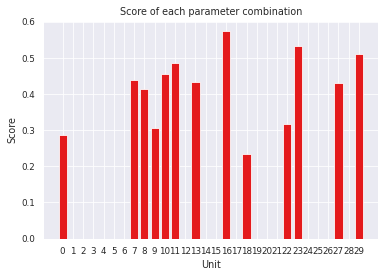

In [116]:
# Scores of our Hyperparameter Optimization
scores = rs_result['mean_test_score'].tolist()

# Positive Score, i.e. each score in scores * (-1)
posScores = []
for s in scores:
    posScores.append(s * (-1))

indices = np.arange(0, len(scores))

plt.bar(indices, posScores, tick_label=indices)
plt.title("Score of each parameter combination")
plt.xlabel("Unit")
plt.ylabel("Score")
# save fig
plt.savefig(fname="scores.png")

Scatter Plot

In [ ]:
### features
features = ['batch_size', 'dropout_rate', 'regularizer_rate', 'learn_rate']

fig, axs = plt.subplots(nrows=len(features), ncols=len(features), figsize=(12, 12))
fig.tight_layout(w_pad=2, h_pad=2)

col = 0
for feature_1 in features:
    row = 0
    for feature_2 in features:
        bestComb = min_rs_results.iloc[0:5]
        rest = min_rs_results.iloc[5:]
        axs[row, col].scatter(bestComb[feature_1], bestComb[feature_2], color='green', alpha=0.7)
        axs[row, col].scatter(rest[feature_1], rest[feature_2], color='red', alpha=0.7)
        axs[row, col].set_xlabel(feature_1, fontsize=9)
        axs[row, col].set_ylabel(feature_2, fontsize=9)
        row = row + 1
    col = col + 1

# save fig
plt.savefig('scoresScatter.png')